In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from matplotlib import pyplot as plt
from torch.optim.lr_scheduler import StepLR

In [2]:
#CIFAR-100（Canadian Institute for Advanced Research - 100 classes）是一个包含100个类别的图像数据集，每个类别包含600张32x32大小的彩色图像。

batch_size=128#批次大小

#数据预处理，采用部分的图片增强技术
transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torchvision.transforms.RandomHorizontalFlip()
    ])

train_dataset=torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset=torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

train_loader=torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
test_loader=torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True,drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.downsample = nn.Sequential()
        
        #保证通道数相等，只有这样才才能相加
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.downsample(x)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)

        x += residual
        x = self.relu(x)
        return x


class ResNet(torch.nn.Module):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(32)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
                
        self.layer1 = ResidualBlock(32,64,stride=1)
        self.layer2 = ResidualBlock(64,128,stride=1)

        self.linear1 = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(128*8*8, 64*4*4), torch.nn.BatchNorm1d(64*4*4), torch.nn.ReLU())
        
        self.lstm = torch.nn.LSTM(input_size=64*4*4, hidden_size=32*4*4, batch_first=True)
        
        self.fc3 = torch.nn.Linear(32*2*2, num_classes)

        self.linear2 = torch.nn.Sequential(torch.nn.Linear(32*4*4, 32*2*2), torch.nn.BatchNorm1d(32*2*2), torch.nn.ReLU())
        self.linear3 = torch.nn.Linear(32*2*2, num_classes)

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.maxpool1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.maxpool3(x)
        x = self.relu3(x)
        
        x = self.layer1(x)
        x = self.layer2(x)

        x = self.linear1(x.reshape(batch_size, 1, -1))
        
        x, y = self.lstm(x)
        
        x = self.linear2(x)
        x = self.linear3(x)

        return x

In [4]:
model=ResNet(100)

In [5]:
#用gpu训练
device = torch.device("cuda")
model = model.to(device)

In [6]:
#定义损失函数（采用交叉熵损失函数）
criterion =nn.CrossEntropyLoss()

#定义优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=0.001)#

#定义学习率调整器
scheduler = StepLR(optimizer, step_size=2, gamma=0.6)#54%

#损失
train_loss_list=[]
test_loss_list=[]
#准确
train_accuracy_list=[]
test_accuracy_list=[]

In [7]:
#训练
def train(epoch):
    model.train(True)
    train_loss=0
    accuracy=0
    correct=0
    
    for idx,(data,target) in enumerate(train_loader):
        
        data,target=data.to(device),target.to(device)
        
        optimizer.zero_grad()#梯度初始化，清除之前的梯度
        
        output = model(data)
        
        loss = criterion(output,target)#对数似然损失
        
        loss.backward()#计算当前梯度，反向传播

        # max_grad_norm = 1  # 设置梯度剪裁的阈值
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()#更新参数

        train_loss+=loss.item()
        
        pred=output.data.max(1,keepdim=True)[1]#找出概率最大值所对应的类别
            
        correct+=pred.eq(target.data.view_as(pred)).sum()#统计正确预测的数量

    train_loss/=len(train_loader.dataset)
    
    accuracy=correct.item()/len(train_loader.dataset)*100
    
    print( 'Epoch:{} \nTrain: loss:{:.8f},accuracy:{}/{} ={:.2f}%'.format (epoch+1,train_loss,correct,len(train_loader.dataset),accuracy))
    
    train_accuracy_list.append(accuracy)
    train_loss_list.append(train_loss)
    

In [8]:
#测试评估
def test():
    test_loss=0
    accuracy=0
    correct=0;
    
    #开启评估模式
    model.eval()

    with torch.no_grad():
        for idx,(data,target) in enumerate(test_loader):
            
            data,target=data.to(device),target.to(device)
            
            output=model(data)
             
            test_loss+=criterion(output,target).item()
            
            pred=output.data.max(1,keepdim=True)[1]#找出概率最大值所对应的类别
            
            correct+=pred.eq(target.data.view_as(pred)).sum()#统计正确预测的数量
            
    test_loss/=len(test_loader.dataset)

    accuracy=correct.item()/len(test_loader.dataset)*100
            
    print("Test: loss:{:.8f},accuracy:{}/{} ={:.2f}%\n".format(test_loss,correct,len(test_loader.dataset),accuracy))
                
    test_accuracy_list.append(accuracy)
    test_loss_list.append(test_loss)
    

In [9]:
#画图
def fig():
    fig, ax1 = plt.subplots()

    # 绘制第一条曲线（Train Loss）在左侧 y 轴上
    ax1.plot(train_loss_list, label='Train Loss', color='green')
    ax1.plot(test_loss_list, label='Test Loss', color='yellow')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='green')
    
    # 创建第二个 y 轴，并绘制第二条曲线（Accuracy）在右侧 y 轴上
    ax2 = ax1.twinx()
    ax2.plot(train_accuracy_list, label='Train Accuracy', color='blue')
    ax2.plot(test_accuracy_list, label='Test Accuracy', color='red')
    ax2.set_ylabel('Accuracy(%)', color='red')
    
    handle1, label1 = ax1.get_legend_handles_labels()
    handle2, label2 = ax2.get_legend_handles_labels()
    ax1.legend(handle1 + handle2, label1 + label2,loc='upper left') 

    plt.show()



Epoch:1 
Train: loss:0.02702688,accuracy:9178/50000 =18.36%
Test: loss:0.02301114,accuracy:2719/10000 =27.19%

Epoch:2 
Train: loss:0.02089000,accuracy:15722/50000 =31.44%
Test: loss:0.02106580,accuracy:3133/10000 =31.33%

Epoch:3 
Train: loss:0.01750228,accuracy:20533/50000 =41.07%
Test: loss:0.01727477,accuracy:4110/10000 =41.10%

Epoch:4 
Train: loss:0.01595697,accuracy:22601/50000 =45.20%
Test: loss:0.01658121,accuracy:4340/10000 =43.40%

Epoch:5 
Train: loss:0.01358338,accuracy:26313/50000 =52.63%
Test: loss:0.01518931,accuracy:4721/10000 =47.21%

Epoch:6 
Train: loss:0.01228298,accuracy:28411/50000 =56.82%
Test: loss:0.01501242,accuracy:4801/10000 =48.01%

Epoch:7 
Train: loss:0.00983391,accuracy:32832/50000 =65.66%
Test: loss:0.01395693,accuracy:5211/10000 =52.11%

Epoch:8 
Train: loss:0.00827736,accuracy:35762/50000 =71.52%
Test: loss:0.01408587,accuracy:5126/10000 =51.26%

Epoch:9 
Train: loss:0.00594557,accuracy:40404/50000 =80.81%
Test: loss:0.01396251,accuracy:5273/10000 =5

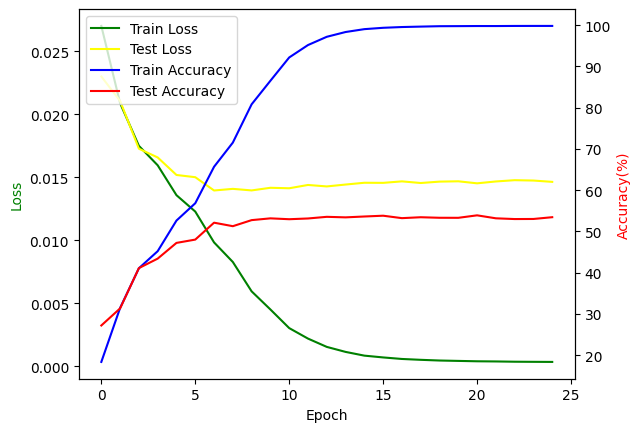

In [10]:
#训练次数
epoch=25

for i in range(epoch):
    train(i)
    scheduler.step()#更新学习率
    test()



fig()

In [11]:
torch.cuda.empty_cache()